In [2]:
#Import packages
import pandas as pd
import requests
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error,explained_variance_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import statsmodels as sm
import statsmodels.api as smf  
from statsmodels.formula.api import ols #formula guide: https://www.statsmodels.org/dev/examples/notebooks/generated/formulas.html

In [3]:
from sklearn.inspection import permutation_importance


def plot_permutation_importance(clf, X, y, ax):
    #conduct permutation feature importance 
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

#Credits of definition:https://scikit-learn.org/stable/modules/permutation_importance.html

### Task 2B
A flat was sold in Nov 2017 with the following characteristics:- Flat type: 4 ROOM
- Town: Yishun
- Flat Model: New Generation
- Storey Range: 10 to 12
- Floor Area (sqm): 91
- Lease Commence Date: 1984
- Resale Price: 550,80


In [5]:
#Global Values

#resale fp
RSF_fp1="Relevant_datasets/RSF90onw_wAddress.csv"

In [6]:
#Import RSF
RSF=pd.read_csv(RSF_fp1,index_col=0,low_memory=False)

In [7]:
##Data prep for ML and regression


# To allow faster training of model , to utilise only 3 years of data
RSF=RSF.loc[(RSF['Year_x']<2020)&(RSF['Year_x']>=2017)]

#to assume a linear relationship btw flat type and resale price.
#assume executive>multi-gen>5 room in general in terms of resale price
RSF['flat_type_n']=0
RSF.loc[RSF['flat_type']=='1 ROOM','flat_type_n']=1
RSF.loc[RSF['flat_type']=='2 ROOM','flat_type_n']=2
RSF.loc[RSF['flat_type']=='3 ROOM','flat_type_n']=3
RSF.loc[RSF['flat_type']=='4 ROOM','flat_type_n']=4
RSF.loc[RSF['flat_type']=='5 ROOM','flat_type_n']=5
RSF.loc[RSF['flat_type']=='MULTI-GENERATION','flat_type_n']=6
RSF.loc[RSF['flat_type']=='MULTI GENERATION','flat_type_n']=6
RSF.loc[RSF['flat_type']=='EXECUTIVE','flat_type_n']=7
print("no. of unchanged rows:",RSF.loc[RSF['flat_type_n']==0]['flat_type_n'].count())

#Create a variable for flat age
RSF['flat_age']=RSF['Year_x']-RSF['lease_commence_date']

##Different dataset was added after coding, town_x was the name of the variable for town, hence will rename town to town_x for simplicity sake
RSF=RSF.rename({'town':'town_x'},axis=1)

no. of unchanged rows: 0


In [8]:
RSF.columns

Index(['month', 'town_x', 'flat_type', 'block', 'street_name_x',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'resale_price', 'remaining_lease', 'street_name_y', 'Lat', 'Lon',
       'street_names_oldver', 'Coordinates', 'rLat', 'rLon', 'Cl_MRT',
       'Distance_MRT_km', 'Year_x', 'Quarter_x', 'Yr_Qt', 'Year_y',
       'Quarter_y', 'Index', 'Real_resale_price', 'flat_type_n', 'flat_age'],
      dtype='object')

In [9]:
##create list of towns to faciliate ease of writing regression formula later as the formula will be very long with many variables


#For easy reference down the line (i.e. when writing regression formula), to replace " " with "_" for town names
RSF['town_x'] = RSF['town_x'].str.replace(' ',"_")
RSF['town_x'] = RSF['town_x'].str.replace('/',"_")

#create a list of unique towns 
town_list=list(RSF['town_x'].unique())

#rename to match its name after converting to dummy var
town_list = ['town_x_' + x for x in town_list]


##convert column to dummy variables 

#create a dummy of towns
RSF_dummies = pd.get_dummies(RSF,columns=['town_x'])

#convert boolean to int for dummy variables to ease regression
for i in town_list:
    RSF_dummies[i] = RSF_dummies[i].astype(int)



In [10]:
RSF[['flat_type_n','town_x','floor_area_sqm','lease_commence_date','resale_price','Year_y']]

,flat_type_n,town_x,floor_area_sqm,lease_commence_date,resale_price,Year_y
746099,2,ANG_MO_KIO,44.0,1979,232000.0,2017
746100,3,ANG_MO_KIO,67.0,1978,250000.0,2017
746101,3,ANG_MO_KIO,67.0,1980,262000.0,2017
746102,3,ANG_MO_KIO,68.0,1980,265000.0,2017
746103,3,ANG_MO_KIO,67.0,1980,265000.0,2017
...,...,...,...,...,...,...
810350,7,YISHUN,142.0,1988,580000.0,2019
810351,7,YISHUN,146.0,1988,565000.0,2019
810352,7,YISHUN,164.0,1992,633000.0,2019
810353,7,YISHUN,164.0,1992,788888.0,2019


In [11]:
#Create new dataframe of dataset to be predicted
New_data={'flat_type_n':[4],'flat_age':[33],'floor_area_sqm':[91],'Year_y':[2017],'town_x_ANG_MO_KIO':0,'town_x_BEDOK':0,
       'town_x_BISHAN':0, 'town_x_BUKIT_BATOK':0, 'town_x_BUKIT_MERAH':0,
       'town_x_BUKIT_PANJANG':0, 'town_x_BUKIT_TIMAH':0, 'town_x_CENTRAL_AREA':0,
       'town_x_CHOA_CHU_KANG':0, 'town_x_CLEMENTI':0, 'town_x_GEYLANG':0,
       'town_x_HOUGANG':0, 'town_x_JURONG_EAST':0, 'town_x_JURONG_WEST':0,
       'town_x_KALLANG_WHAMPOA':0, 'town_x_MARINE_PARADE':0, 'town_x_PASIR_RIS':0,
       'town_x_PUNGGOL':0, 'town_x_QUEENSTOWN':0, 'town_x_SEMBAWANG':0,
       'town_x_SENGKANG':0, 'town_x_SERANGOON':0, 'town_x_TAMPINES':0,
       'town_x_TOA_PAYOH':0, 'town_x_WOODLANDS':0}
New_df=pd.DataFrame(New_data,columns=['flat_type_n','flat_age','Year_y','floor_area_sqm','town_x_ANG_MO_KIO','town_x_BEDOK',
       'town_x_BISHAN', 'town_x_BUKIT_BATOK', 'town_x_BUKIT_MERAH',
       'town_x_BUKIT_PANJANG', 'town_x_BUKIT_TIMAH', 'town_x_CENTRAL_AREA',
       'town_x_CHOA_CHU_KANG', 'town_x_CLEMENTI', 'town_x_GEYLANG',
       'town_x_HOUGANG', 'town_x_JURONG_EAST', 'town_x_JURONG_WEST',
       'town_x_KALLANG_WHAMPOA', 'town_x_MARINE_PARADE', 'town_x_PASIR_RIS',
       'town_x_PUNGGOL', 'town_x_QUEENSTOWN', 'town_x_SEMBAWANG',
       'town_x_SENGKANG', 'town_x_SERANGOON', 'town_x_TAMPINES',
       'town_x_TOA_PAYOH', 'town_x_WOODLANDS'])

In [12]:
#remove Yishun from list before adding to ols formula later to prevent multicollinearity (1 town needs to be absent during regression)
town_list.remove('town_x_YISHUN')

#checking if yishun is still in the list
if 'town_YISHUN' in town_list:
    print("Yishun is in the list")
else:
    print("Yishun is not in the list")

str_town = ' + '.join(town_list)

print(str_town)

Yishun is not in the list
town_x_ANG_MO_KIO + town_x_BEDOK + town_x_BISHAN + town_x_BUKIT_BATOK + town_x_BUKIT_MERAH + town_x_BUKIT_PANJANG + town_x_BUKIT_TIMAH + town_x_CENTRAL_AREA + town_x_CHOA_CHU_KANG + town_x_CLEMENTI + town_x_GEYLANG + town_x_HOUGANG + town_x_JURONG_EAST + town_x_JURONG_WEST + town_x_KALLANG_WHAMPOA + town_x_MARINE_PARADE + town_x_PASIR_RIS + town_x_PUNGGOL + town_x_QUEENSTOWN + town_x_SEMBAWANG + town_x_SENGKANG + town_x_SERANGOON + town_x_TAMPINES + town_x_TOA_PAYOH + town_x_WOODLANDS


In [13]:
#Get a subset of the dataframe before train test split
RSF_ML=RSF_dummies[['resale_price','flat_type_n','flat_age','Year_y','floor_area_sqm','town_x_ANG_MO_KIO','town_x_BEDOK',
       'town_x_BISHAN', 'town_x_BUKIT_BATOK', 'town_x_BUKIT_MERAH',
       'town_x_BUKIT_PANJANG', 'town_x_BUKIT_TIMAH', 'town_x_CENTRAL_AREA',
       'town_x_CHOA_CHU_KANG', 'town_x_CLEMENTI', 'town_x_GEYLANG',
       'town_x_HOUGANG', 'town_x_JURONG_EAST', 'town_x_JURONG_WEST',
       'town_x_KALLANG_WHAMPOA', 'town_x_MARINE_PARADE', 'town_x_PASIR_RIS',
       'town_x_PUNGGOL', 'town_x_QUEENSTOWN', 'town_x_SEMBAWANG',
       'town_x_SENGKANG', 'town_x_SERANGOON', 'town_x_TAMPINES',
       'town_x_TOA_PAYOH', 'town_x_WOODLANDS']]

In [14]:
#Create a train and test set
X_train, X_test, y_train, y_test = train_test_split(RSF_ML.drop('resale_price', axis=1), RSF_ML['resale_price'], test_size=0.25, random_state=100)

## Ridge regression

In [16]:
##Perform Ridge regression using Gridsearch cv

from sklearn.metrics import get_scorer
from sklearn.metrics import get_scorer_names
## Create a decision tree model

#create 10 floats from 0.01-100
lin_space=np.linspace(0.01, 100, 10)
#determine parameters of decision tree
params=[{'alpha': lin_space}]

scorer=['neg_mean_absolute_error','neg_mean_absolute_percentage_error','explained_variance']

R_GS = GridSearchCV(Ridge(),
                      param_grid=params,
                      scoring=scorer,refit='neg_mean_absolute_error',
                      cv=5,n_jobs=-1)

R_GS.fit(X_train, y_train)
R_GS.best_params_
R_GS.score(X_train, y_train)  
R_best_estimator = R_GS.best_estimator_

print(f"Best estimator has alpha value of {R_GS.best_params_['alpha']} ")
y_pred = R_best_estimator.predict(X_test)
print("mean absolute error: ",mean_absolute_error(y_test, y_pred))
print("neg_mean_absolute_percentage_error: ",mean_absolute_percentage_error(y_test,y_pred))
print("explained_variance: ",explained_variance_score(y_test, y_pred))

Best estimator has alpha value of 11.12 
mean absolute error:  49445.45510054077
neg_mean_absolute_percentage_error:  0.11805736750187337
explained_variance:  0.8196947976367649


In [17]:
print("Predicted price:",R_best_estimator.predict(New_df)[0])

Predicted price: 319230.8660112205


In [18]:
R_best_estimator.coef_


array([ 19845.25514514,  -5605.43293798,   -935.54305977,   3629.38949185,
       126039.71050478, 106851.72234981, 221665.46353079,  23246.31226483,
       229375.10691893, -27655.12251133, 295024.76861873, 297903.24991183,
       -83307.81014883, 162156.6205374 , 157607.17412883,  24514.94932703,
        48970.50156576, -31689.74935245, 186037.61044787, 266228.67534172,
       -13699.68571173, -33408.98779051, 244650.14289398, -98705.64380426,
       -45570.27135783, 103689.62877437,  62531.43926947, 186931.18404703,
       -72402.22700264])

### Utilising a Decision tree model
As decision trees are able to predict with categorical variables, the data used will be different. \
Categorical variables like flat model and flat type (unencoded) will be used, town will not be turn to dummy variables.

In [20]:
from sklearn.metrics import get_scorer
from sklearn.metrics import get_scorer_names
## Create a decision tree model

#create 4 evenly spaced integers from 1-10
lin_space=np.linspace(2, 10, 4)
lin_space=[int(x) for x in lin_space]

#create 10 evenly spaced integers
lin_space_min_sample=np.linspace(2, 200, 8)
lin_space_min_sample=[int(x) for x in lin_space]

#determine parameters of decision tree
params=[{'min_samples_leaf': lin_space_min_sample,
         'criterion': ['absolute_error'],
         'max_depth':lin_space}]

scorer=['neg_mean_absolute_error','neg_mean_absolute_percentage_error','explained_variance']

DTM_GS = GridSearchCV(DecisionTreeRegressor(),
                      param_grid=params,
                      scoring=scorer,refit='neg_mean_absolute_error',
                      cv=5,n_jobs=-1)

DTM_GS.fit(X_train, y_train)
DTM_GS.best_params_
DTM_GS.score(X_train, y_train)  
DTM_GS_best_estimator = DTM_GS.best_estimator_

print(f"Best estimator has {DTM_GS.best_params_['min_samples_leaf']} minimum samples per leaf,uses {DTM_GS.best_params_['criterion']} criterion and Max depth of {DTM_GS.best_params_['max_depth']} splits")
y_pred = DTM_GS_best_estimator.predict(X_test)
print("mean absolute error: ",mean_absolute_error(y_test, y_pred))
print("neg_mean_absolute_percentage_error: ",mean_absolute_percentage_error(y_test,y_pred))
print("explained_variance: ",explained_variance_score(y_test, y_pred))

Best estimator has 4 minimum samples per leaf,uses absolute_error criterion and Max depth of 10 splits
mean absolute error:  46995.78673555777
neg_mean_absolute_percentage_error:  0.10373380292952036
explained_variance:  0.7949130283639607


In [21]:
## Exploring the tree

# Predict the class label for a single observation
observation = New_df  # take the first observation from the test set
prediction = DTM_GS_best_estimator.predict(New_df)  # reshape to (1, n_features)
print(prediction)
# Get the decision path for the observation
decision_path = DTM_GS_best_estimator.decision_path(New_df)


[380000.]


In [22]:
decision_path = DTM_GS_best_estimator.decision_path(New_df)
node_indices = decision_path.nonzero()[1]

In [23]:
##Trying to understand the path which the decision tree took to come to its decisions

from sklearn.tree import plot_tree

# Get the tree structure from the decision tree object
tree = DTM_GS_best_estimator.tree_

# Iterate over the node indices and get the node information
for node_idx in node_indices:
    print(f"Node {node_idx}:")
    print(f"  Feature: {tree.feature[node_idx]}")
    print(f"  Feature: {New_df.columns[tree.feature[node_idx]]}")
    print(f"  Threshold: {tree.threshold[node_idx]}")
    print(f"  Left child: {tree.children_left[node_idx]}")
    print(f"  Right child: {tree.children_right[node_idx]}")

Node 0:
  Feature: 3
  Feature: floor_area_sqm
  Threshold: 84.5
  Left child: 1
  Right child: 368
Node 368:
  Feature: 3
  Feature: floor_area_sqm
  Threshold: 111.5
  Left child: 369
  Right child: 670
Node 369:
  Feature: 8
  Feature: town_x_BUKIT_MERAH
  Threshold: 0.5
  Left child: 370
  Right child: 565
Node 370:
  Feature: 22
  Feature: town_x_QUEENSTOWN
  Threshold: 0.5
  Left child: 371
  Right child: 492
Node 371:
  Feature: 1
  Feature: flat_age
  Threshold: 13.5
  Left child: 372
  Right child: 431
Node 431:
  Feature: 28
  Feature: town_x_WOODLANDS
  Threshold: 0.5
  Left child: 432
  Right child: 461
Node 432:
  Feature: 6
  Feature: town_x_BISHAN
  Threshold: 0.5
  Left child: 433
  Right child: 448
Node 433:
  Feature: 12
  Feature: town_x_CHOA_CHU_KANG
  Threshold: 0.5
  Left child: 434
  Right child: 441
Node 434:
  Feature: 3
  Feature: floor_area_sqm
  Threshold: 104.5
  Left child: 435
  Right child: 438
Node 435:
  Feature: 26
  Feature: town_x_TAMPINES
  Thresho

In [24]:
from sklearn.inspection import permutation_importance
r = permutation_importance(R_best_estimator, X_train, y_train,
                           n_repeats=30,
                           random_state=0)

PFI_01_tn=pd.DataFrame(columns=[])

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8}"+" ,Mean:"+
              f"{r.importances_mean[i]:.3f}"+", std:"+
              f" +/- {r.importances_std[i]:.3f}")
    New_data={'feature':[X_train.columns[i]],'Mean':[r.importances_mean[i]],'Std':[r.importances_std[i]]}
    PFI_01_tn = pd.concat([PFI_01_tn, pd.DataFrame(New_data)], ignore_index=True)
PFI_01_tn

floor_area_sqm ,Mean:0.655, std: +/- 0.003
flat_age ,Mean:0.412, std: +/- 0.003
town_x_BUKIT_MERAH ,Mean:0.175, std: +/- 0.002
town_x_QUEENSTOWN ,Mean:0.130, std: +/- 0.001
town_x_TOA_PAYOH ,Mean:0.098, std: +/- 0.001
town_x_KALLANG_WHAMPOA ,Mean:0.085, std: +/- 0.001
town_x_BISHAN ,Mean:0.082, std: +/- 0.001
town_x_CENTRAL_AREA ,Mean:0.067, std: +/- 0.001
town_x_ANG_MO_KIO ,Mean:0.059, std: +/- 0.001
town_x_GEYLANG ,Mean:0.050, std: +/- 0.001
town_x_BEDOK ,Mean:0.049, std: +/- 0.001
town_x_CLEMENTI ,Mean:0.047, std: +/- 0.001
flat_type_n ,Mean:0.041, std: +/- 0.001
town_x_MARINE_PARADE ,Mean:0.038, std: +/- 0.001
town_x_WOODLANDS ,Mean:0.032, std: +/- 0.001
town_x_BUKIT_TIMAH ,Mean:0.024, std: +/- 0.000
town_x_CHOA_CHU_KANG ,Mean:0.023, std: +/- 0.000
town_x_SEMBAWANG ,Mean:0.022, std: +/- 0.000
town_x_TAMPINES ,Mean:0.020, std: +/- 0.000
town_x_SERANGOON ,Mean:0.019, std: +/- 0.000
town_x_SENGKANG ,Mean:0.012, std: +/- 0.000
town_x_JURONG_WEST ,Mean:0.006, std: +/- 0.000
town_x_PUNGG

,feature,Mean,Std
0,floor_area_sqm,0.654658,0.003148
1,flat_age,0.411511,0.003049
2,town_x_BUKIT_MERAH,0.174981,0.001698
3,town_x_QUEENSTOWN,0.130110,0.001075
4,town_x_TOA_PAYOH,0.098352,0.000800
5,town_x_KALLANG_WHAMPOA,0.085499,0.000731
6,town_x_BISHAN,0.081708,0.000728
7,town_x_CENTRAL_AREA,0.066919,0.000869
8,town_x_ANG_MO_KIO,0.058580,0.000765
9,town_x_GEYLANG,0.050201,0.000589


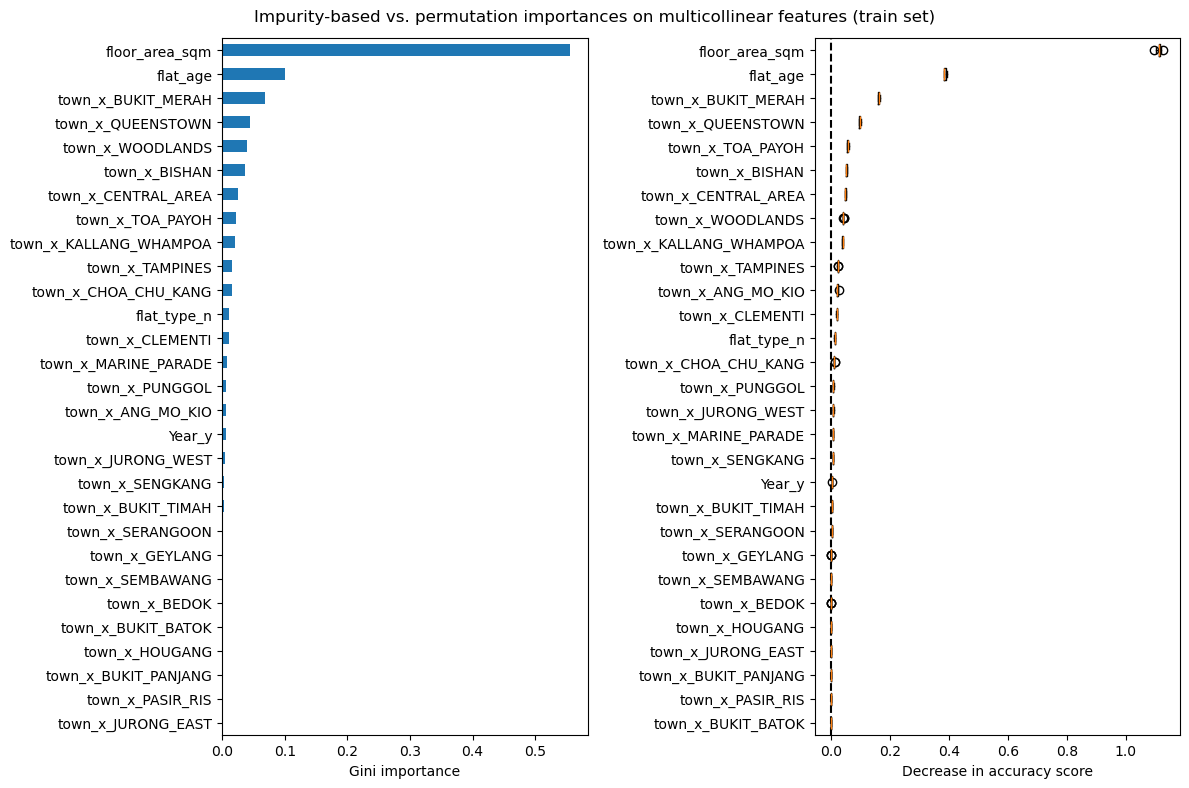

In [25]:
mdi_importances = pd.Series(DTM_GS_best_estimator.feature_importances_, index=X_train.columns)
tree_importance_sorted_idx = np.argsort(DTM_GS_best_estimator.feature_importances_)
tree_indices = np.arange(0, len(DTM_GS_best_estimator.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
mdi_importances.sort_values().plot.barh(ax=ax1)
ax1.set_xlabel("Gini importance")
plot_permutation_importance(DTM_GS_best_estimator, X_train, y_train, ax2)
ax2.set_xlabel("Decrease in accuracy score")
fig.suptitle(
    "Impurity-based vs. permutation importances on multicollinear features (train set)"
)
_ = fig.tight_layout()


#credits to: https://scikit-learn.org/stable/modules/permutation_importance.html
#credits to:https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
#credits to:https://stackoverflow.com/questions/71618530/how-come-you-can-get-a-permutation-feature-importance-greater-than-1
#credits to:https://en.wikipedia.org/wiki/Coefficient_of_determination

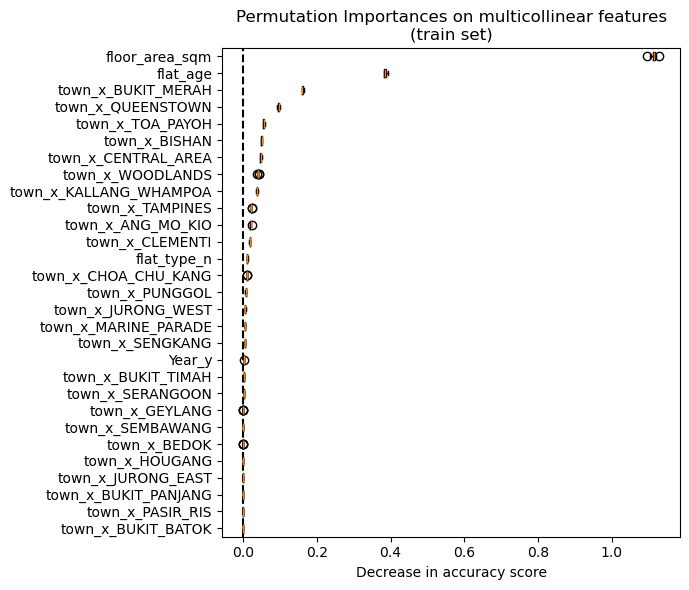

In [26]:
fig, ax = plt.subplots(figsize=(7, 6))
#Conduct and plot permutation feature importance
plot_permutation_importance(DTM_GS_best_estimator, X_train, y_train, ax)
ax.set_title("Permutation Importances on multicollinear features\n(train set)")
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

#Export image
plt.savefig('Relevant_datasets/2_B/PFI_01_PFI_train.png')

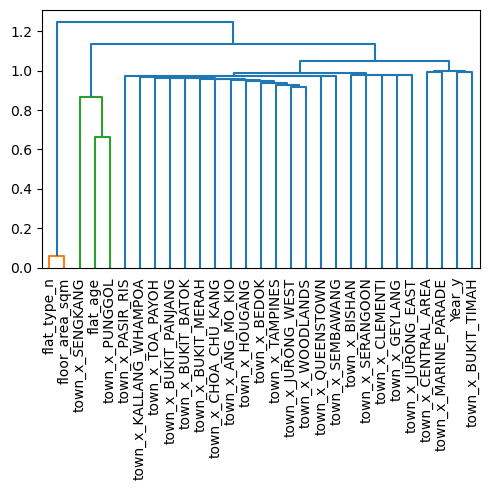

In [27]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
#conduct spearman rank order correlation 
corr = spearmanr(X_train).correlation
# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X_train.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()
#Will manually pick 1 variable from clusters to minimise multicollinearity

#Export image
plt.savefig('Relevant_datasets/2_B/PFI_04_Dendrogram_feat.png')

#Credits for codes: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

In [28]:
X_train_sel = X_train[['floor_area_sqm','flat_age','flat_type_n','town_x_CENTRAL_AREA','town_x_BUKIT_MERAH','town_x_JURONG_WEST','town_x_MARINE_PARADE','town_x_SENGKANG','town_x_PUNGGOL']]
X_test_sel = X_test[['floor_area_sqm','flat_age','flat_type_n','town_x_CENTRAL_AREA','town_x_BUKIT_MERAH','town_x_JURONG_WEST','town_x_MARINE_PARADE','town_x_SENGKANG','town_x_PUNGGOL']]
#The best estimator has 2 minimum samples per leaf,uses absolute_error criterion and Max depth of 10 splits,we will follow this

DTR = DecisionTreeRegressor(criterion='absolute_error',min_samples_leaf=2,max_depth=10, random_state=42)
DTR.fit(X_train_sel, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=10,
                      min_samples_leaf=2, random_state=42)

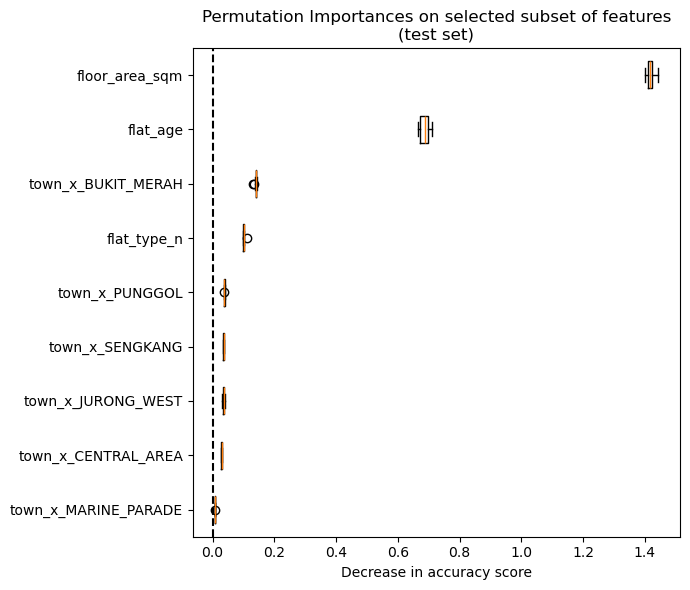

In [29]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(DTR, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

#Export image
plt.savefig('Relevant_datasets/2_B/PFI_03_Training_feat.png')
plt.show()

In [30]:
r = permutation_importance(DTR, X_test_sel, y_test,
                           n_repeats=30,
                           random_state=42)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8}"+" ,Mean:"+
              f"{r.importances_mean[i]:.3f}"+", std:"+
              f" +/- {r.importances_std[i]:.3f}")

flat_type_n ,Mean:1.420, std: +/- 0.016
flat_age ,Mean:0.686, std: +/- 0.013
town_x_ANG_MO_KIO ,Mean:0.138, std: +/- 0.004
Year_y   ,Mean:0.103, std: +/- 0.004
town_x_BUKIT_MERAH ,Mean:0.038, std: +/- 0.001
town_x_BUKIT_BATOK ,Mean:0.036, std: +/- 0.001
town_x_BEDOK ,Mean:0.035, std: +/- 0.002
floor_area_sqm ,Mean:0.030, std: +/- 0.002
town_x_BISHAN ,Mean:0.008, std: +/- 0.000
